In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

## Parâmetros

In [2]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

# fig preprocessing
largura = 150
altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [3]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

,image,target
0,./PokemonData/Pidgey/3fcbfdf9bc1a4939a6a1e925e...,Pidgey
1,./PokemonData/Gyarados/df34553d71614fff94c296f...,Gyarados
2,./PokemonData/Articuno/a578b22d32444703996dbfa...,Articuno
3,./PokemonData/Jynx/f8873d29d70146d48dee15434fe...,Jynx
4,./PokemonData/Rapidash/18364a83c2c14d03ae1010a...,Rapidash
...,...,...
6820,./PokemonData/Arbok/af4df6d456224941b6faae231d...,Arbok
6821,./PokemonData/Pidgeot/6487a566693e435d92b10851...,Pidgeot
6822,./PokemonData/Ponyta/a46b81cef6494c6f984a44a57...,Ponyta
6823,./PokemonData/Koffing/36ea6b7f28ac4a77802be5fe...,Koffing


## Analisando Dados

In [4]:
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


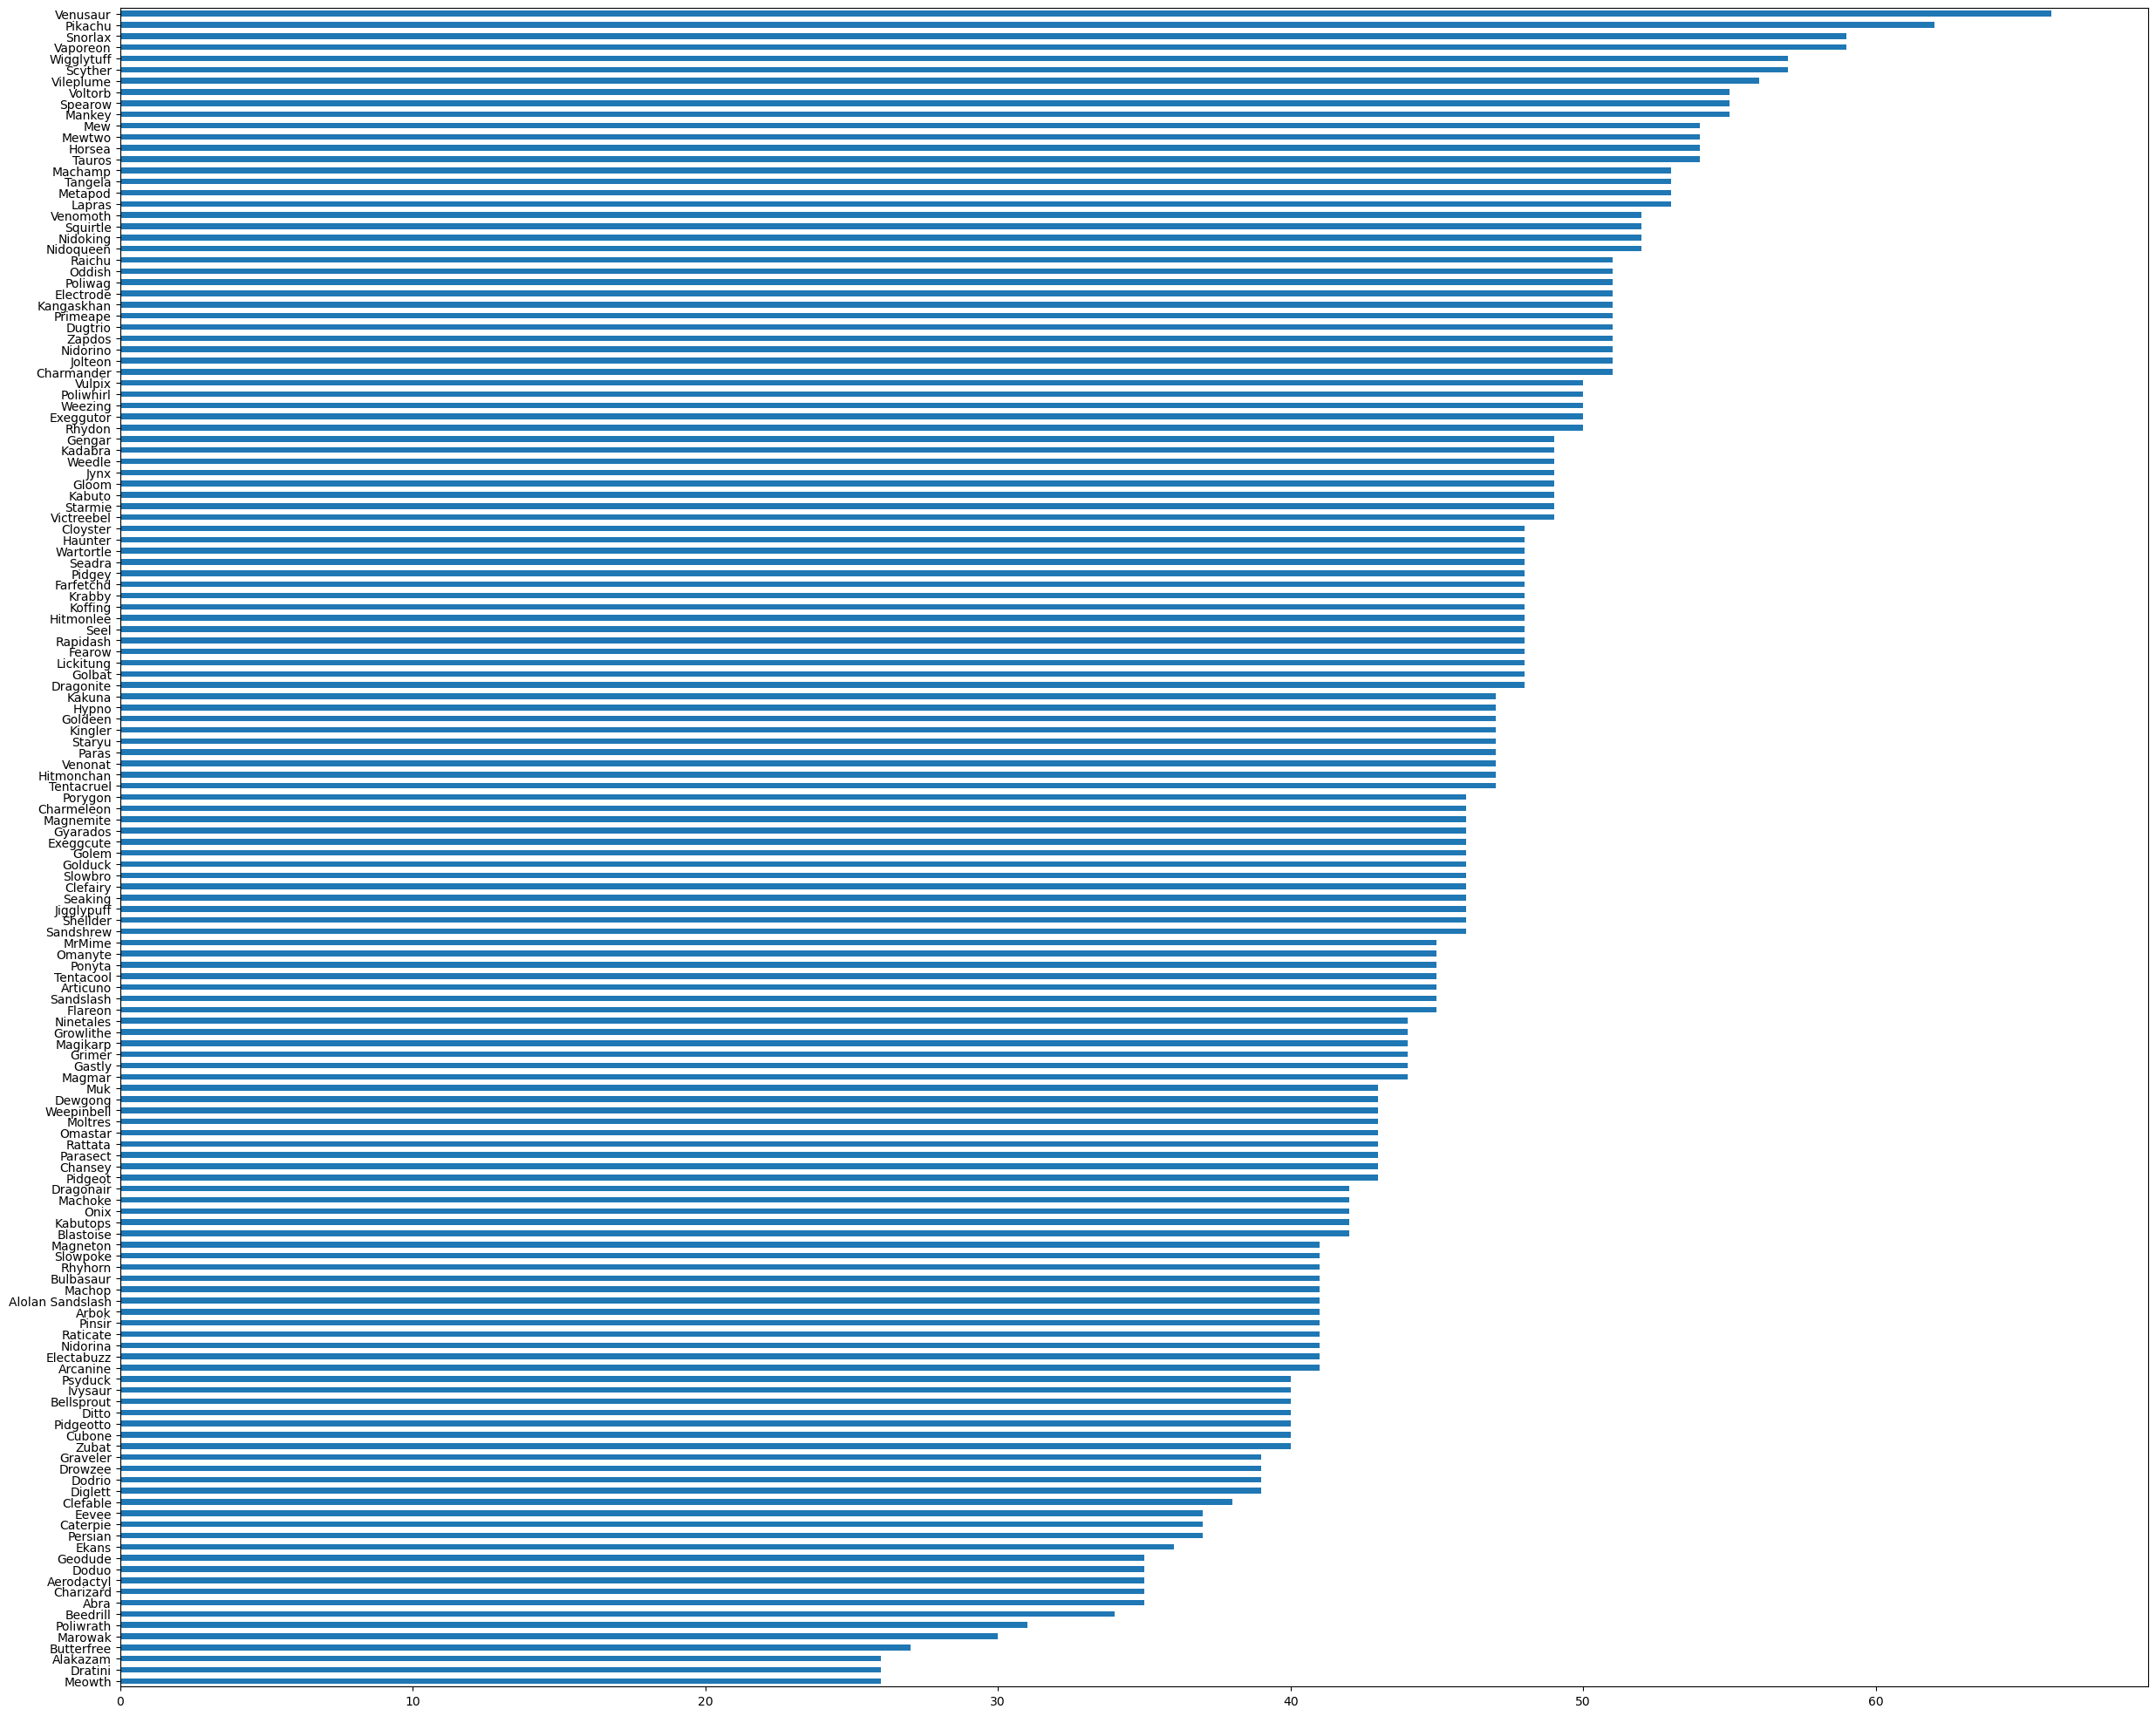

In [5]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [6]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

In [7]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [8]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [9]:
largura = math.floor(median_width)
altura = math.floor(median_height)

pixels = []

for filename in df_dados['image']:
    img = image.load_img(filename, target_size=(largura, altura),color_mode= modo_de_cor)
    
    # converter a imagem em uma matriz numpy
    img_array = np.array(img)
    # adicionar a matriz de pixels
    pixels.append(img_array)
    
# converter a lista de pixels em uma matriz numpy
pixels = np.array(pixels)

# achatá-la em uma matriz 2D de pixels
pixels = pixels.reshape(-1, pixels.shape[-1])

plt.figure(figsize=(10,8))
# traçar o histograma dos pixels
plt.hist(pixels.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.8)

plt.xlabel('Valor do pixel')
plt.ylabel('Frequência')
plt.title('Histograma de cores')

plt.show()

## Preparando Dados

In [25]:
def getEmbedder():
    # return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    # return EfficientNetB3(weights='imagenet', include_top=False)
    # return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    return InceptionV3(weights='imagenet', include_top=False)

def embedding(embedder, img_path, largura, altura, modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
        # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

def embeddingWithoutModel(img_path, largura, altura, modo_de_cor):
    
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    
    shape_entrada = largura*altura*1

    if(modo_de_cor == 'rgb'):
        shape_entrada = largura*altura*3

    if(modo_de_cor == 'rgba'):
        shape_entrada = largura*altura*4
    
    return embed.reshape(shape_entrada)

embedder = getEmbedder()

In [ ]:
target = df_dados['target'].array

array_features = []
for x in dados:
    array_features.append(embedding(embedder, x[0], largura, altura, modo_de_cor))
    # array_features.append(embeddingWithoutModel(x[0], largura, altura, modo_de_cor))

scaler = preprocessing.StandardScaler()

# array_features = np.array(array_features, dtype=np.uint8)

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

1/1 [==============================] - 1s 832ms/step


## Reduzindo a Dimensionalidade

In [ ]:
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50)
array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.savefig(f"Embedding {getEmbedder().name}", bbox_inches="tight")

plt.show()

## Treinando e Validando o Modelo

In [ ]:
def getModel():
    return RandomForestClassifier(n_jobs=20)
    # return LogisticRegression()#n_jobs=20, solver='sag', multi_class='ovr')
    # return KNeighborsClassifier(n_neighbors=3,n_jobs=20)
    # return XGBClassifier()
    # return SGDClassifier(n_jobs=20,early_stopping=True,validation_fraction=0.05)

In [ ]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target,test_size=percentege_test_size)

model = getModel().fit(X_treino, y_treino)

score = model.score(X_teste, y_teste)

score

## Validando

In [ ]:
scores = cross_val_score(getModel(),df_features.values,target,cv=5)

np.mean(scores)

## Visualizando Matriz de Confusão

In [ ]:
predicoes = cross_val_predict(getModel(),df_features.values,target,cv=5)

cm = confusion_matrix(target, predicoes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()